In [75]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers.recurrent import LSTM
from keras.layers import Embedding,Concatenate,Activation,Input, merge,Merge,Dense, Dropout,Flatten,Reshape,Convolution1D,MaxPooling1D,Convolution2D,MaxPooling2D,TimeDistributed,Lambda
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.optimizers import Adam,SGD,RMSprop,Adadelta
from keras.layers.advanced_activations import LeakyReLU
from IPython.core.display import HTML
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import model_from_json
from keras import backend
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
backend.set_image_dim_ordering('tf')

In [3]:
#Environment Data
place_one = "良"
place_two ="良"
place_three ="良"

In [4]:
# coding: shift_jisx0213

In [102]:
COLUMNS = ["year","month","date","kaiji","place","index","race_num","race_name","class_code","track","corse_code","distance","condition",
           "horse_name","horse_sex","horse_age","jockey","load_weight","heads_count","horse_num","finish_order","finish_orderP","ijyou",
           "margin","ninki","time","time_clock","non","lap1","lap2","lap3","lap4","3F","horse_weight","trainer","attach","prize","family_line",
           "jockey_code","trainer_code","race_id","horse_owner","producer","father","mother","m_father","hair_color","birthday","odds",
           "horse_mark","race_mark","PCI"]

COLUMNS2 = ["date","place","race_num","horse_num","race_name","track","distance","horse_name","horse_sex","horse_age","jockey",
            "load_weight","trainer","attach","non1","non2","father","mother","non5","non6","m_father","non8","non9","non10","non11","non12",
            "non13","non14","non15","non16","non17","non18","non19","non20","non21","non22","non23","non24","non25","non26",
            "non27","non28"]


DCOLUMNS= ["month","date","kaiji","index","class_code","corse_code","finish_orderP","ijyou",
           "margin","ninki","time_clock","non","lap1","lap2","lap3","lap4","3F","prize","family_line",
           "jockey_code","trainer_code","race_id","horse_owner","producer","hair_color","birthday","heads_count","condition","horse_weight",
           "horse_mark","race_mark","PCI","m_father","father","mother","heads_count","attach","trainer","race_num"]

DCOLUMNS2 = ["non1","non2","non5","non6","non8","non9","non10","non11","non12","non13",
            "non14","non15","non16","non17","non18","non19","non20","non21","non22","non23","non24","non25","non26",
            "non27","non28","date","m_father","mother","father","attach","trainer","race_num"]


In [103]:
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

In [104]:
df_train_all = pd.read_csv('/Users/pp/jupyter/horse_data/DS170604.CSV', names = COLUMNS, engine='python',encoding="shift_jisx0213",
                           converters = {'horse_name' : strip},skiprows = 1)
df_train = df_train_all.drop(DCOLUMNS,axis=1)

In [8]:
df_train_all2 = pd.read_csv('/Users/pp/jupyter/horse_data/INPUT5.csv', names = COLUMNS, engine='python',encoding="shift_jisx0213",
                           converters = {'horse_name' : strip},skiprows = 1)
df_train2 = df_train_all2.drop(DCOLUMNS,axis=1)

In [105]:
df_prediction_all = pd.read_csv('/Users/pp/jupyter/prediction_data/DE170604.CSV', names = COLUMNS2, engine='python',
                                encoding="shift_jisx0213",converters = {'Description' : strip},skiprows = 1)
df_prediction = df_prediction_all.drop(DCOLUMNS2,axis=1)
df_prediction = df_prediction[df_prediction["race_name"] != u"新馬"]
df = pd.DataFrame(columns = ["year","finish_order","odds"])
df_prediction = pd.concat([df,df_prediction],axis=1)
df_prediction["year"] = 17
df_prediction["finish_order"] = None

df_prediction = df_prediction.ix[:,["year","place","race_name","track","distance","horse_name","horse_sex","horse_age","jockey",
                                   "load_weight","horse_num","finish_order"]]

In [106]:
df_all = pd.concat([df_train,df_prediction],axis=0)
df_all = df_all.reset_index(drop=True)

In [10]:
df_all = pd.concat([df_train,df_train2,df_prediction],axis=0)
df_all = df_all.reset_index(drop=True)

NameError: name 'df_train2' is not defined

In [36]:
HTML(df_all.tail(30).to_html())

,distance,finish_order,horse_age,horse_name,horse_num,horse_sex,jockey,load_weight,odds,place,race_name,time,track,year
3874,1400,None,4,ベルクリア,12,牝,浜中俊,55.0,NaN,阪神,洲本特別1000,NaN,ダ,17
3875,1400,None,4,ヨシオ,13,牡,川又賢治,57.0,NaN,阪神,洲本特別1000,NaN,ダ,17
3876,1400,None,6,メイショウボンロク,14,牡,太宰啓介,57.0,NaN,阪神,洲本特別1000,NaN,ダ,17
3877,1400,None,5,ザイディックメア,15,牡,小崎綾也,57.0,NaN,阪神,洲本特別1000,NaN,ダ,17
3878,1400,None,4,ワンダーリーデル,16,牡,和田竜二,57.0,NaN,阪神,洲本特別1000,NaN,ダ,17
3879,2400,None,5,クィーンチャーム,1,牝,秋山真一,52.0,NaN,阪神,グリーＨ1600,NaN,芝,17
3880,2400,None,4,リッチーリッチー,2,牡,小牧太,57.0,NaN,阪神,グリーＨ1600,NaN,芝,17
3881,2400,None,6,レイズアスピリット,3,牡,幸英明,56.0,NaN,阪神,グリーＨ1600,NaN,芝,17
3882,2400,None,6,ザトゥルーエアー,4,牡,藤岡康太,55.0,NaN,阪神,グリーＨ1600,NaN,芝,17
3883,2400,None,8,スズカルパン,5,牡,和田竜二,55.0,NaN,阪神,グリーＨ1600,NaN,芝,17


In [107]:
LE = df_all.copy()
d = defaultdict(LabelEncoder)
LE = LE.drop(["distance","horse_age","horse_num","year","finish_order","time"], axis =1)
# Encoding the variable
Encoded = LE.apply(lambda x: d[x.name].fit_transform(x))
Encoded_all = pd.concat([Encoded,df_all["distance"],df_all["horse_age"],df_all["horse_num"],df_all["year"],df_all["finish_order"],
                        df_all["time"]], axis=1)

# Inverse the encoded
Decoded = Encoded.apply(lambda x: d[x.name].inverse_transform(x))

In [38]:
#データ少ない
split = df_train.shape[0]

train_x = Encoded_all[0:split]
prediction_x = Encoded_all[split:]

In [14]:
#データ多い
split = df_train.shape[0] + df_train2.shape[0]

train_x = Encoded_all[0:split]
prediction_x = Encoded_all[split:]

NameError: name 'df_train2' is not defined

In [ ]:
train_y = train_x["finish_order"].copy()
for i in range(len(train_x)):
    if train_y.iloc[i] < 4:
        train_y.iloc[i] = 1
    else:
        train_y.iloc[i] = 0
train_x = train_x.drop(["finish_order"],axis=1)

In [ ]:
train_x = pd.concat([train_x,train_y],axis = 1)

In [ ]:
m=0
train_order = pd.DataFrame(columns = ["place","race_name","track","condition","horse_name","horse_sex","jockey","trainer","horse_weight",
                                      "distance","horse_age","odds","horse_num","finish_order"])
for i in range(len(train_x)/16):
    for j in range(17):
        temp = train_x[m:j+m]
    temp2 = temp.sort_values(by='horse_num')
    train_order = pd.concat([train_order, temp2])
    m = m +16

In [39]:
prediction_x.shape

(320, 14)

In [40]:
#horse_reorder = train_x.sort_values(by=['horse_name','year'],ascending=[True,False])

In [41]:
horse_reorder = train_x
mode = horse_reorder["horse_name"].value_counts().index.tolist()

In [50]:
train_x

,horse_name,horse_sex,jockey,load_weight,odds,place,race_name,track,distance,horse_age,horse_num,year,finish_order,time
0,281,1,189,5,0,1,408,1,1600,3,10,17,14,95.9
1,281,1,155,5,2593,8,408,1,1600,3,6,17,13,96.3
2,281,1,170,4,2594,2,411,0,1800,2,14,16,13,121.0
3,281,1,155,5,2595,8,411,1,1400,2,12,16,6,84.0
4,281,1,61,5,2596,7,409,1,2000,2,4,16,8,126.2
5,281,1,61,5,2597,7,379,1,1800,2,2,16,6,113.0
6,186,1,42,5,2598,6,410,0,1800,3,15,17,11,119.5
7,186,1,198,2,2599,8,410,0,1400,3,12,17,9,86.9
8,186,1,178,4,2600,3,408,0,1800,3,11,17,12,117.5
9,186,1,164,5,2601,8,410,0,1400,3,1,17,13,90.1


In [18]:
horse_db_list = []
y_label_list = []
validation_xl = []
validation_yl = []
v = []
horse_reorder_db = horse_reorder.drop(["finish_order"],axis = 1)
prediction_db = prediction_x.drop(["finish_order"],axis=1)
#並び替えた時のインデックスがmode
mode = horse_reorder_db["horse_name"].value_counts().index.tolist()
for i in range(len(mode)):
    try:
        H = horse_reorder_db[horse_reorder_db['horse_name'] == mode[i]]
    #train　と test　でインデックスが不一致の時
    except:
        i = i+1
        H = horse_reorder_db[horse_reorder_db['horse_name'] == mode[i]]
        P = prediction_db[prediction_db['horse_name'] == mode[i]].iloc[0]
        
    if horse_reorder_db['horse_name'].value_counts().iloc[i] > 4:
        H1 = H.iloc[0]
        H2 = H.iloc[1]
        H3 = H.iloc[2]
        horse_db_list.append(H1)
        horse_db_list.append(H2)
        horse_db_list.append(H3)
        
        try:
            if prediction_db[prediction_db['horse_name'] == mode[i]]["horse_name"].iloc[0] in mode:
                P = prediction_db[prediction_db['horse_name'] == mode[i]].iloc[0]
                validation_xl.append(H2)
                validation_xl.append(H3)
                validation_xl.append(P)
                v.append(P)
        except:
            k = 0
            
        H_label = horse_reorder[horse_reorder['horse_name'] == mode[i]]
        L1 = H_label["finish_order"].iloc[0]
        L2 = H_label["finish_order"].iloc[1]
        L3 = H_label["finish_order"].iloc[2]
        y_label_list.append(L1)
        y_label_list.append(L2)
        y_label_list.append(L3)
        
validation_x_df = pd.DataFrame(validation_xl, columns=["year","place","race_name","track","distance","horse_name","horse_sex","horse_age","jockey",
                                   "load_weight","horse_num","race_num"])
validation_x_df_reordered =  validation_x_df.sort_values(by=['place','race_num','horse_num','horse_name'],
                                                                     ascending=[True,True,True,True])
horse_db = np.array(horse_db_list)
y_db = np.array(y_label_list)
validation_x = np.array(validation_xl)

In [83]:
horse_db_list = []
y_label_list = []
y_label_list_t = []
validation_xl = []
validation_yl = []
v = []
horse_reorder_db = horse_reorder.drop(["finish_order","time"],axis = 1)
prediction_db = prediction_x.drop(["finish_order","time"],axis=1)
#並び替えた時のインデックスがmode
mode = horse_reorder_db["horse_name"].value_counts().index.tolist()
for i in range(len(mode)):
    try:
        H = horse_reorder_db[horse_reorder_db['horse_name'] == mode[i]]
    #train　と test　でインデックスが不一致の時
    except:
        i = i+1
        H = horse_reorder_db[horse_reorder_db['horse_name'] == mode[i]]
        P = prediction_db[prediction_db['horse_name'] == mode[i]].iloc[0]
        
    if horse_reorder_db['horse_name'].value_counts().iloc[i] > 6:
        H1 = H.iloc[0]
        H2 = H.iloc[1]
        H3 = H.iloc[2]
        H4 = H.iloc[3]
        H5 = H.iloc[4]
        horse_db_list.append(H1)
        horse_db_list.append(H2)
        horse_db_list.append(H3)
        horse_db_list.append(H4)
        horse_db_list.append(H5)
        
        try:
            if prediction_db[prediction_db['horse_name'] == mode[i]]["horse_name"].iloc[0] in mode:
                P = prediction_db[prediction_db['horse_name'] == mode[i]].iloc[0]
                validation_xl.append(H2)
                validation_xl.append(H3)
                validation_xl.append(H4)
                validation_xl.append(H5)
                validation_xl.append(P)
                v.append(P)
        except:
            k = 0
            
        H_label = horse_reorder[horse_reorder['horse_name'] == mode[i]]
        L1 = H_label["finish_order"].iloc[0]
        L2 = H_label["finish_order"].iloc[1]
        L3 = H_label["finish_order"].iloc[2]
        L4 = H_label["finish_order"].iloc[3]
        L5 = H_label["finish_order"].iloc[4]
        y_label_list.append(L1)
        y_label_list.append(L2)
        y_label_list.append(L3)
        y_label_list.append(L4)
        y_label_list.append(L5)
        L1_t = H_label["time"].iloc[0]
        L2_t = H_label["time"].iloc[1]
        L3_t = H_label["time"].iloc[2]
        L4_t = H_label["time"].iloc[3]
        L5_t = H_label["time"].iloc[4]
        y_label_list_t.append(L1_t)
        y_label_list_t.append(L2_t)
        y_label_list_t.append(L3_t)
        y_label_list_t.append(L4_t)
        y_label_list_t.append(L5_t)
        

horse_db = np.array(horse_db_list)
y_db_f = np.array(y_label_list)
y_db_f =  np_utils.to_categorical(y_db_f)
y_db_t = np.array(y_label_list_t)
y_db = np.c_[y_db_f,y_db_t]
validation_x = np.array(validation_xl)

In [85]:
pd.DataFrame(y_db).shape

(845, 20)

In [114]:
y_db_t

array([ 118.2,  144.4,  106.7,  120.1,   93.3,   84.6,   72.4,   85.5,
         85.8,   72.3,  193.2,  107.1,  107. ,  122. ,  118.1,   84.3,
         83.1,   84.4,   85.1,   84.4,  106.8,   99.1,  114.9,  105.2,
        106.7,   83.6,   85.6,  107.2,   84.1,   86.9,  135.1,  121.5,
        158.4,  158.6,  155.6,   83.3,   95.4,   93.8,  120.6,  107.8,
        120.1,  106.8,   93.7,  107.5,   93.3,   96.9,  157.2,   98.4,
        133.2,   97.4,  120.4,  136.1,  122.2,  121.3,  109.2,  107. ,
        119.4,  121.4,  121.4,  121.5,   97.1,  106.8,  154.1,  110. ,
        115.5,   92.5,   95.5,   82.7,   82.1,   94.5,   84.2,   84. ,
         83.9,   85.7,   97.9,   82.2,  122.9,  126.7,  152.3,  109.5,
         95.3,   93.8,  124.3,   94.6,   93.4,  114.8,  114.4,  207.7,
        203.4,  201.5,  117.5,  108.4,  120.8,  121.9,  120. ,   85.1,
         86.2,   84.2,   84.4,   85. ,  107.8,   93.6,  119.9,  107.6,
         93. ,   73.1,   72.9,   70.4,   69.3,   69.5,   72.1,   71.1,
      

In [ ]:
list_all = []
race_list = []
m=0
for j in range(len(train_x)/18):
    for i in range(18):
        df1 = train_order["place"].iloc[i+m]
        df2 = train_order["race_name"].iloc[i+m]
        df3 = train_order["track"].iloc[i+m]
        df4 = train_order["condition"].iloc[i+m]
        df5 = train_order["horse_name"].iloc[i+m]
        df6 = train_order["horse_sex"].iloc[i+m]
        df7 = train_order["jockey"].iloc[i+m]
        df8 = train_order["trainer"].iloc[i+m]

        df9 = train_order["horse_weight"].iloc[i+m]
        df10 = train_order["distance"].iloc[i+m]
        df11 = train_order["horse_age"].iloc[i+m]
        df12 = train_order["horse_num"].iloc[i+m]
        df13 = train_order["odds"].iloc[i+m]

        list_m2 = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13]
        race_list.append(list_m2)
        
    list_all.append(race_list)
    m = m+ 16
    race_list = []
seq_array = np.array(list_all)

In [20]:
train_x

,horse_name,horse_sex,jockey,load_weight,odds,place,race_name,track,distance,horse_age,horse_num,year,finish_order
0,281,1,189,5,0,1,408,1,1600,3,10,17,14
1,281,1,155,5,2593,8,408,1,1600,3,6,17,13
2,281,1,170,4,2594,2,411,0,1800,2,14,16,13
3,281,1,155,5,2595,8,411,1,1400,2,12,16,6
4,281,1,61,5,2596,7,409,1,2000,2,4,16,8
5,281,1,61,5,2597,7,379,1,1800,2,2,16,6
6,186,1,42,5,2598,6,410,0,1800,3,15,17,11
7,186,1,198,2,2599,8,410,0,1400,3,12,17,9
8,186,1,178,4,2600,3,408,0,1800,3,11,17,12
9,186,1,164,5,2601,8,410,0,1400,3,1,17,13


In [21]:
pd.DataFrame(validation_xl)

,horse_name,horse_sex,jockey,load_weight,odds,place,race_name,track,distance,horse_age,horse_num,year
3193,111,2,189,5,1880,3,469,1,2400,8,3,17
3194,111,2,96,11,1881,10,594,1,1800,8,1,17
3195,111,2,96,5,1882,10,230,1,2000,8,10,17
3196,111,2,73,5,1883,10,435,1,1600,8,8,17
3883,111,2,73,7,1289,10,80,1,2400,8,5,17
1884,135,2,70,11,3194,2,639,0,1200,7,16,17
1885,135,2,188,11,3195,1,577,0,1400,7,5,17
1886,135,2,57,11,3196,3,0,0,1400,7,10,17
1887,135,2,138,11,3197,2,0,0,1200,7,5,17
3753,135,2,151,11,1416,8,189,0,1600,7,13,17


In [21]:
#y_db =  np_utils.to_categorical(y_db)
#validation_y =  np_utils.to_categorical(validation_y)

In [22]:
y_db.shape

(845,)

In [23]:
horse_db.shape

(845, 12)

In [24]:
validation_x.shape

(840, 12)

In [25]:
nb_filter = 32
nb_filter2 = 32
Input_length_db = horse_db.shape[1]
feature_length = horse_db.shape[1]
embedding_size = 30
batch = 5

In [26]:
# Input
Input_main = Input(shape = (Input_length_db,), dtype='float32')

In [125]:
#Embedding layer for all categorical inputs
#input dim は最大インデックス数, input_lengthは入力の長さ
e = Embedding(output_dim=embedding_size, input_dim=25000, input_length=Input_length_db)(Input_main)


#border_modeはCNNをゼロパディングするかしないか
conv1 = Convolution1D(nb_filter = 32, filter_length=2, border_mode = 'same', activation='relu')(e)
pooling = MaxPooling1D(pool_length=2)(conv1)

LSTM_input = LSTM(batch)(pooling)

dense = Dense(20)(LSTM_input)
#output 
output = Dense(19, activation = 'softmax')(dense)

/Users/pp/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", filters=32, kernel_size=2)`
/Users/pp/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


In [126]:
dense

<tf.Tensor 'dense_22/BiasAdd:0' shape=(?, 20) dtype=float32>

In [119]:
#Embedding layer for all categorical inputs
#input dim は最大インデックス数, input_lengthは入力の長さ
e = Embedding(output_dim=embedding_size, input_dim=25000, input_length=Input_length_db)(Input_main)


#border_modeはCNNをゼロパディングするかしないか
conv1 = Convolution1D(nb_filter = 32, filter_length=2, border_mode = 'same', activation='relu')(e)
pooling = MaxPooling1D(pool_length=2)(conv1)

LSTM_input = LSTM(batch)(pooling)

d1 = Dense(20)(pooling)
d2 = Dense(10)(LSTM_input)
#output 
output1 = Dense(19, activation = 'softmax')(pooling)
output2 = Dense(1)(d2)

/Users/pp/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", filters=32, kernel_size=2)`
/Users/pp/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


In [120]:
output1

<tf.Tensor 'dense_20/Softmax:0' shape=(?, 19) dtype=float32>

In [127]:
model = Model(input = Input_main, output = [output])
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

/Users/pp/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  if __name__ == '__main__':


In [ ]:
model = Model(input = Input_main, output = [output1,output2])
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
model.compile(loss = ['categorical_crossentropy','mse'], optimizer = adam, metrics=['accuracy'])

In [128]:
history = model.fit(horse_db,[y_db],batch_size = batch, epochs = 100, shuffle = False)

ValueError: Error when checking model target: expected dense_23 to have shape (None, 19) but got array with shape (845, 20)

In [ ]:
Input_sequence = Input(shape=(18,13))
prosessed_sequence = TimeDistributed(model)(Input_sequence)
seq_encoder = LSTM(18)(prosessed_sequence)

dense1 = Dense(20, activation='relu')(reshaped3)
b1 = BatchNormalization()(dense1)

dense2 = Dense(15, activation='relu')(b1)
b2 = BatchNormalization()(dense2)

dense3 = Dense(16, activation='relu')(b2)
b3 = BatchNormalization()(dense3)

reshaped4 = Reshape((16,1))(b3)

time_dense = TimeDistributed(Dense(16, activation='relu'))(reshaped4)
output_seq = Dense(1, activation='linear')(time_dense)

In [ ]:
H = model.evaluate(validation_x,validation_y,batch_size=batch)

In [ ]:
#invailed argument matrix size incompatable はbatch_sizeを直す
#validation を変える

/Users/pp/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "upper_left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


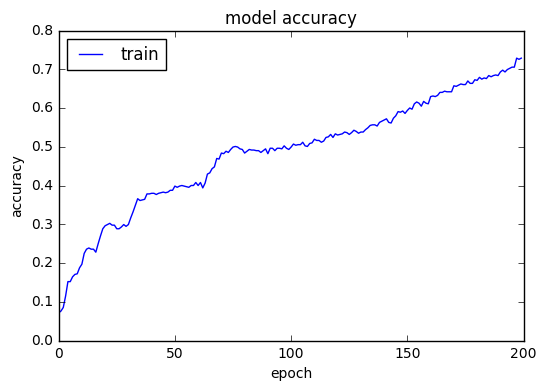

In [31]:
#surrarize results for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = "upper_left")

f_name = '/Users/pp/jupyter/graph/HDBi_RNN5_CNN_categorical_acc.png'
plt.savefig(f_name)
plt.show()

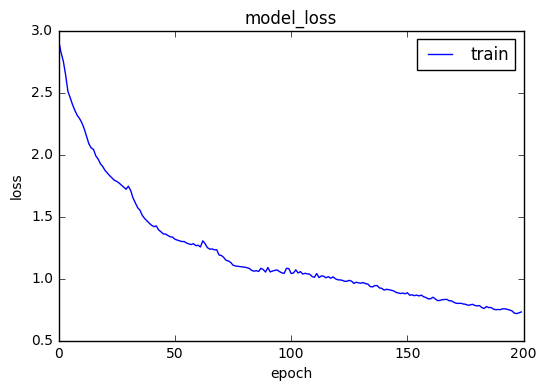

In [32]:
#summarize results for loss
plt.plot(history.history['loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper_left')

f_name = '/Users/pp/jupyter/graph/HDB_RNN5_CNN_categorical_loss.png'
plt.savefig(f_name)
plt.show()

In [33]:
model.save_weights('/Users/pp/jupyter/traindata_HDB_few1.h5py')

In [123]:
prediction0 = model.predict(validation_x, batch_size=batch)

In [124]:
pd.DataFrame(prediction0)

,0
0,"[[0.00395703, 0.158129, 0.118224, 0.0453301, 0..."
1,"[[101.538], [101.536], [101.536], [101.538], [..."


In [92]:
#time+FO
predicted_df = pd.DataFrame(prediction0)
v_cols = pd.DataFrame(validation_xl).drop(["year","place","track","distance","horse_sex","horse_age","load_weight","horse_num","odds"],axis=1)
v_cols2 = v_cols.apply(lambda x: d[x.name].inverse_transform(x))
v_cols2 = pd.concat([v_cols2,pd.DataFrame(validation_xl)["horse_num"]],axis=1)
v_cols.index = range(0,len(v_cols))
v_cols2.index = range(0,len(v_cols2))
results = pd.concat([v_cols2,predicted_df],axis=1)
results.columns = ["horse_name","jockey","race_name","horse_num","1","2","3","4","5","6","7","8","9","10","11","12","13","14",
                       "15","16","17","18","19","time"]
#unicodeのエラーはdfを最初から読み込めば解決する

In [108]:
predicted_df = pd.DataFrame(prediction0)
v_cols = pd.DataFrame(validation_xl).drop(["year","place","track","distance","horse_sex","horse_age","load_weight","horse_num","odds"],axis=1)
v_cols2 = v_cols.apply(lambda x: d[x.name].inverse_transform(x))
v_cols2 = pd.concat([v_cols2,pd.DataFrame(validation_xl)["horse_num"]],axis=1)
v_cols.index = range(0,len(v_cols))
v_cols2.index = range(0,len(v_cols2))
results = pd.concat([v_cols2,predicted_df],axis=1)
results.columns = ["horse_name","jockey","race_name","horse_num","1","2","3","4","5","6","7","8","9","10","11","12","13","14",
                       "15","16","17","18","19"]
#unicodeのエラーはdfを最初から読み込めば解決する

ValueError: Length mismatch: Expected axis has 5 elements, new values have 23 elements

In [93]:
Todays_race = pd.DataFrame(columns = ["race_name","horse_name","jockey","horse_num","1","2","3","4","5","6","7","8","9","10","11","12","13","14",
                        "15","16","17","18","19","time"])
t = []
n = 1
m = 1
#当日のレースのみを抽出
for i in range(len(results)/batch-batch):
    m = batch*n-1
    temp = results.iloc[m]
    t.append(temp)
    n = n + 1
Todays_race = pd.DataFrame(t)
Todays_race_R = Todays_race.sort_values(by=['race_name','horse_num'],ascending=[True,True])
Todays_race_R = Todays_race_R.round(6)

In [94]:
df_results = pd.read_csv("/Users/pp/jupyter/results/20170604.csv", engine='python',encoding="shift_jisx0213")
df_results = df_results.sort_values(by=[u'レース名',u'馬番'],ascending=[True,True])
temp = []
d = pd.DataFrame(columns=["Finish_order","Prediction"])
Todays_result = pd.concat([Todays_race_R,d],axis=1)
#Todays_race_Rの着順を検索し、Todays_resultsにcancat
for i in range(len(Todays_race_R)):
    try:
        name = Todays_race_R["horse_name"].iloc[i]
        t = df_results.loc[df_results[u"馬名"] == name][u"着順"].values[0]
        t_val = int(t)
        Todays_result["Finish_order"].iloc[i] = t_val
    except:
        i = i 
        
#一位と二位の出現数をカウント
win_pred = []
for i in range(len(Todays_race_R)):
    p_val = Todays_race_R.iloc[i][5:].argmax()
    Todays_result["Prediction"].iloc[i] = p_val
    win_pred.append(p_val)

/Users/pp/anaconda/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [95]:
Todays_race_R

,horse_name,jockey,race_name,horse_num,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,time
29,ビタミンエース,荻野極,500万下,1,0.002690,0.098738,0.088205,0.079919,0.089523,0.090447,...,0.062627,0.055399,0.043264,0.037068,0.033100,0.017461,0.015198,0.000096,0.002625,26.154140
84,アイファーマグオー,荻野極,500万下,1,0.002688,0.098761,0.088208,0.079924,0.089530,0.090451,...,0.062633,0.055399,0.043258,0.037063,0.033099,0.017455,0.015191,0.000096,0.002622,26.163410
719,ロードサンダー,菊沢一樹,500万下,1,0.002688,0.098777,0.088218,0.079923,0.089518,0.090446,...,0.062639,0.055398,0.043257,0.037066,0.033100,0.017453,0.015192,0.000096,0.002622,26.162142
269,ビレッジゴールド,横山和生,500万下,2,0.002685,0.098818,0.088234,0.079927,0.089509,0.090442,...,0.062653,0.055395,0.043252,0.037065,0.033101,0.017446,0.015186,0.000095,0.002620,26.169643
549,カプリチオーソ,森裕太朗,500万下,2,0.002686,0.098809,0.088231,0.079926,0.089511,0.090443,...,0.062650,0.055396,0.043253,0.037065,0.033100,0.017447,0.015187,0.000096,0.002620,26.168282
144,ナニスンネン,和田竜二,500万下,3,0.002690,0.098719,0.088191,0.079922,0.089538,0.090455,...,0.062619,0.055402,0.043263,0.037063,0.033098,0.017463,0.015197,0.000096,0.002624,26.155695
439,プエルト,北村宏司,500万下,3,0.002692,0.098683,0.088177,0.079918,0.089546,0.090457,...,0.062608,0.055404,0.043268,0.037064,0.033098,0.017470,0.015202,0.000096,0.002626,26.149063
554,オーミパドドゥ,岡田祥嗣,500万下,3,0.002698,0.098583,0.088143,0.079907,0.089562,0.090463,...,0.062577,0.055407,0.043284,0.037069,0.033096,0.017490,0.015218,0.000096,0.002632,26.129354
669,アンティクイーン,佐藤友則,500万下,4,0.002694,0.098668,0.088181,0.079911,0.089534,0.090450,...,0.062605,0.055401,0.043275,0.037072,0.033099,0.017475,0.015210,0.000096,0.002629,26.139503
774,ピアノイッチョウ,吉田豊,500万下,4,0.002692,0.098710,0.088197,0.079914,0.089524,0.090447,...,0.062619,0.055399,0.043269,0.037071,0.033099,0.017467,0.015204,0.000096,0.002627,26.146662


In [96]:
HTML(Todays_result.to_html())

,horse_name,jockey,race_name,horse_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,time,Finish_order,Prediction
29,ビタミンエース,荻野極,500万下,1,0.002690,0.098738,0.088205,0.079919,0.089523,0.090447,0.082247,0.073401,0.082437,0.045554,0.062627,0.055399,0.043264,0.037068,0.033100,0.017461,0.015198,0.000096,0.002625,26.154140,9,time
84,アイファーマグオー,荻野極,500万下,1,0.002688,0.098761,0.088208,0.079924,0.089530,0.090451,0.082252,0.073396,0.082434,0.045540,0.062633,0.055399,0.043258,0.037063,0.033099,0.017455,0.015191,0.000096,0.002622,26.163410,9,time
719,ロードサンダー,菊沢一樹,500万下,1,0.002688,0.098777,0.088218,0.079923,0.089518,0.090446,0.082247,0.073384,0.082434,0.045543,0.062639,0.055398,0.043257,0.037066,0.033100,0.017453,0.015192,0.000096,0.002622,26.162142,14,time
269,ビレッジゴールド,横山和生,500万下,2,0.002685,0.098818,0.088234,0.079927,0.089509,0.090442,0.082244,0.073364,0.082429,0.045534,0.062653,0.055395,0.043252,0.037065,0.033101,0.017446,0.015186,0.000095,0.002620,26.169643,4,time
549,カプリチオーソ,森裕太朗,500万下,2,0.002686,0.098809,0.088231,0.079926,0.089511,0.090443,0.082245,0.073368,0.082430,0.045536,0.062650,0.055396,0.043253,0.037065,0.033100,0.017447,0.015187,0.000096,0.002620,26.168282,11,time
144,ナニスンネン,和田竜二,500万下,3,0.002690,0.098719,0.088191,0.079922,0.089538,0.090455,0.082255,0.073418,0.082437,0.045549,0.062619,0.055402,0.043263,0.037063,0.033098,0.017463,0.015197,0.000096,0.002624,26.155695,7,time
439,プエルト,北村宏司,500万下,3,0.002692,0.098683,0.088177,0.079918,0.089546,0.090457,0.082256,0.073434,0.082442,0.045558,0.062608,0.055404,0.043268,0.037064,0.033098,0.017470,0.015202,0.000096,0.002626,26.149063,6,time
554,オーミパドドゥ,岡田祥嗣,500万下,3,0.002698,0.098583,0.088143,0.079907,0.089562,0.090463,0.082260,0.073480,0.082451,0.045584,0.062577,0.055407,0.043284,0.037069,0.033096,0.017490,0.015218,0.000096,0.002632,26.129354,11,time
669,アンティクイーン,佐藤友則,500万下,4,0.002694,0.098668,0.088181,0.079911,0.089534,0.090450,0.082249,0.073433,0.082445,0.045573,0.062605,0.055401,0.043275,0.037072,0.033099,0.017475,0.015210,0.000096,0.002629,26.139503,12,time
774,ピアノイッチョウ,吉田豊,500万下,4,0.002692,0.098710,0.088197,0.079914,0.089524,0.090447,0.082246,0.073412,0.082440,0.045564,0.062619,0.055399,0.043269,0.037071,0.033099,0.017467,0.015204,0.000096,0.002627,26.146662,15,time


In [90]:
#再現率の計算
first = Todays_result.loc[Todays_result["Finish_order"] == 1]
second = Todays_result.loc[Todays_result["Finish_order"] == 2]
win_pred1 = []
win_pred2 = []
for i in range(len(first)):
    temp = first.iloc[i][5:23].argmax()
    temp2 = second.iloc[i][5:23].argmax()
    win_pred1.append(temp)
    win_pred2.append(temp2)
#一位のなかで一位と二位と予測したものの数を数える
win_count1 = win_pred1.count('2') + win_pred1.count('3')
#二位のなかで一位と二位と予測したものの数を数える
win_count2 = win_pred2.count('2') + win_pred2.count('3')
win_count = win_count1 + win_count2
Recall = float(win_count1)/float(len(win_pred1))
print(Recall)

0.384615384615


In [174]:
win_count1

0

In [104]:
filter((lambda x: x=='2'),win_pred)

['2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2']

In [129]:
HTML(Todays_result.to_html())

,race_name,horse_name,jockey,horse_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Finish_order
17,500万下,ビタミンエース,荻野極,1,0.003858,0.000085,0.000235,0.002013,0.001743,0.012428,0.000062,0.000916,0.002310,0.078843,0.000077,0.189350,0.097953,0.024725,0.250231,0.245712,0.078159,0.0,0.011303,9
50,500万下,アイファーマグオー,荻野極,1,0.001639,0.000281,0.004403,0.258195,0.003202,0.229791,0.007989,0.422748,0.021274,0.022582,0.009936,0.000123,0.016043,0.000003,0.000084,0.000360,0.001084,0.0,0.000262,9
431,500万下,ロードサンダー,菊沢一樹,1,0.010120,0.000002,0.000027,0.057888,0.023000,0.005857,0.000388,0.014462,0.000076,0.370611,0.000683,0.000513,0.375127,0.000063,0.002899,0.014709,0.118358,0.0,0.005218,14
161,500万下,ビレッジゴールド,横山和生,2,0.000085,0.029583,0.099768,0.078761,0.145615,0.008371,0.326689,0.018062,0.001428,0.004375,0.282489,0.000013,0.004561,0.000100,0.000003,0.000015,0.000070,0.0,0.000013,4
329,500万下,カプリチオーソ,森裕太朗,2,0.001303,0.000222,0.003349,0.100359,0.000387,0.452493,0.001726,0.336576,0.081039,0.010840,0.002081,0.000454,0.007244,0.000003,0.000230,0.000648,0.000755,0.0,0.000291,11
86,500万下,ナニスンネン,和田竜二,3,0.000084,0.025672,0.089905,0.082277,0.151520,0.007830,0.327675,0.018445,0.001242,0.004440,0.286105,0.000011,0.004611,0.000085,0.000003,0.000014,0.000069,0.0,0.000013,7
263,500万下,プエルト,北村宏司,3,0.000104,0.038655,0.126224,0.081860,0.126243,0.012264,0.312791,0.021366,0.002438,0.004917,0.267746,0.000024,0.005093,0.000143,0.000006,0.000023,0.000085,0.0,0.000018,6
332,500万下,オーミパドドゥ,岡田祥嗣,3,0.001757,0.000114,0.000237,0.000647,0.000559,0.009470,0.000027,0.000356,0.003104,0.030854,0.000031,0.318741,0.039273,0.038420,0.299463,0.214356,0.035729,0.0,0.006865,11
401,500万下,アンティクイーン,佐藤友則,4,0.010425,0.000002,0.000028,0.068896,0.022847,0.006739,0.000435,0.018262,0.000085,0.371858,0.000770,0.000433,0.368697,0.000047,0.002432,0.012878,0.110227,0.0,0.004940,12
464,500万下,ピアノイッチョウ,吉田豊,4,0.008072,0.000001,0.000009,0.032290,0.026039,0.001991,0.000207,0.005558,0.000019,0.365571,0.000381,0.000345,0.394536,0.000069,0.002627,0.014162,0.143361,0.0,0.004761,15


In [49]:
Todays_race_R.dtypes

race_name      object
horse_name     object
jockey         object
horse_num       int64
1             float64
2             float64
3             float64
4             float64
5             float64
6             float64
7             float64
8             float64
9             float64
10            float64
11            float64
12            float64
13            float64
14            float64
15            float64
16            float64
17            float64
18            float64
19            float64
dtype: object

In [115]:
results

,race_name,horse_name,jockey,horse_num,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,烏丸ＳＨ1600,スズカルパン,藤岡康太,3,0.000311,0.001203,0.010004,0.238764,0.011064,0.000412,...,0.020732,0.004710,0.000150,0.006485,0.003494,0.000302,0.002723,0.000579,0.000002,0.000212
1,難波Ｓ1600,スズカルパン,小牧太,1,0.000264,0.001118,0.009544,0.241773,0.011075,0.000327,...,0.019432,0.004292,0.000119,0.006357,0.002861,0.000230,0.002270,0.000488,0.000002,0.000179
2,グリーＨ1600,スズカルパン,和田竜二,5,0.000545,0.333682,0.220395,0.011519,0.017975,0.128112,...,0.044154,0.005210,0.104954,0.022044,0.071351,0.019144,0.003116,0.009313,0.000007,0.000405
3,鹿島特別1000,タッチシタイ,吉田豊,16,0.005908,0.000190,0.001553,0.059998,0.002821,0.006738,...,0.007497,0.024541,0.002076,0.002189,0.028922,0.016148,0.100403,0.007070,0.000012,0.004737
4,鈴鹿特別1000,タッチシタイ,藤岡佑介,5,0.001454,0.013995,0.005433,0.000209,0.001508,0.431532,...,0.000996,0.008023,0.365864,0.002451,0.039375,0.085487,0.014588,0.026851,0.000004,0.001368
5,三浦特別1000,タッチシタイ,武豊,13,0.000272,0.001419,0.011763,0.258112,0.011020,0.000394,...,0.024425,0.004020,0.000144,0.006476,0.003662,0.000288,0.002301,0.000516,0.000002,0.000182
6,小倉大賞ＨG3,クランモンタナ,松若風馬,5,0.000837,0.001227,0.005463,0.009309,0.000070,0.032188,...,0.055594,0.000270,0.011207,0.000098,0.588913,0.264113,0.011288,0.001526,0.000008,0.000549
7,チャレンＨG3,クランモンタナ,和田竜二,12,0.000638,0.061672,0.053752,0.023877,0.342243,0.009814,...,0.003143,0.095815,0.008245,0.239847,0.001135,0.000269,0.003657,0.010714,0.000003,0.000559
8,障害未勝利,クランモンタナ,熊沢重文,9,0.000273,0.001262,0.010247,0.242013,0.013102,0.000346,...,0.018720,0.004911,0.000128,0.007480,0.002686,0.000218,0.002311,0.000534,0.000002,0.000186
9,天王寺Ｈ1000,ロゼッタストーン,松山弘平,3,0.001368,0.001642,0.005154,0.005580,0.000120,0.065177,...,0.030538,0.000638,0.025468,0.000175,0.498285,0.330878,0.018758,0.003358,0.000009,0.000964


In [186]:
prediction0[0:20]

array([[  9.39458332e-05,   3.19369227e-01,   2.17836648e-01,
          3.72977220e-02,   5.57158962e-02,   1.16528712e-01,
          3.89470495e-02,   3.46895424e-03,   1.65072381e-02,
          2.07833364e-03,   3.34011726e-02,   1.52641341e-01,
          7.20204262e-04,   2.44894181e-04,   9.62754566e-05,
          1.16660631e-04,   4.92502516e-03,   1.72046128e-08,
          1.06620128e-05],
       [  3.36206140e-05,   5.51682618e-03,   9.14214831e-03,
          9.28360038e-04,   4.14945275e-01,   2.35615554e-03,
          5.07350802e-01,   8.53907131e-03,   1.47168044e-04,
          6.43598905e-05,   5.06389828e-04,   3.06160804e-02,
          1.13964043e-05,   6.45048078e-03,   8.17584712e-03,
          4.76091309e-03,   2.49817298e-04,   5.83771360e-08,
          2.05124146e-04],
       [  8.14284140e-05,   4.73188236e-03,   1.02970758e-02,
          2.23942893e-03,   3.90555739e-01,   1.90026779e-03,
          5.22691846e-01,   6.87778043e-03,   1.25077189e-04,
          1.3510

In [ ]:
validation_y[0:20]

In [ ]:
y_classes = keras.np_utils.probas_to_classes(prediction0)

In [ ]:
prediction = sequence_model.predict([x_validation_seq,x_validation])

In [ ]:
prediction[3]

In [ ]:
time_prediction = pd.DataFrame(prediction,columns=["predicted_time"])

In [ ]:
time_prediction = pd.concat([prediction_set,time_prediction],axis=1)

In [ ]:
time_prediction

In [ ]:
date = 3

In [ ]:
time_prediction.to_csv("/Users/pp/jupyter/time_prediction_CNN_horseTree%d.csv"%date,encoding="shift_jisx0213")